# Optimizer Testing

## Load Packages

In [1]:
import numpy as np
import pandas as pd
import keras
from keras.utils import plot_model
from keras import applications
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Bidirectional, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Lambda, MaxPool2D, BatchNormalization, Input, concatenate, Reshape, LSTM, CuDNNLSTM
#from keras.layers import K
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop, Adam
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import xml.etree.ElementTree as ET
import sklearn
import itertools
import cv2
import scipy
import os
import csv
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm

# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

Using TensorFlow backend.


In [2]:
class1 = {1:'NEUTROPHIL',2:'EOSINOPHIL',3:'MONOCYTE',4:'LYMPHOCYTE'}
class2 = {0:'Mononuclear',1:'Polynuclear'}
tree_path = 'C:\\Users\\Chris\\Blood Cells\\BCCD_Dataset-master\\BCCD\\Annotations'
image_path = 'C:\\Users\\Chris\\Blood Cells\\BCCD_Dataset-master\\BCCD\\JPEGImages'

## Define Helper Functions and Load Data

In [3]:
def get_data(folder, size):
    """
    Load the data and labels from the given folder.
    """
    X = []
    y = []
    z = []
    for wbc_type in os.listdir(folder):
        if not wbc_type.startswith('.'):
            if wbc_type in ['NEUTROPHIL']:
                label = 1
                label2 = 1
            elif wbc_type in ['EOSINOPHIL']:
                label = 2
                label2 = 1
            elif wbc_type in ['MONOCYTE']:
                label = 3  
                label2 = 0
            elif wbc_type in ['LYMPHOCYTE']:
                label = 4 
                label2 = 0
            else:
                label = 5
                label2 = 0
            for image_filename in tqdm(os.listdir(folder + wbc_type)):
                img_file = cv2.imread(folder + wbc_type + '/' + image_filename)
                if img_file is not None:
                    img_file = cv2.resize(img_file, dsize=size)
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
                    z.append(label2)
    X = np.asarray(X)
    y = np.asarray(y)
    z = np.asarray(z)
    return X,y,z

def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history['acc'])
    plt.plot(history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    #plt.clf()
    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

In [4]:
size=(64, 64)
X_train, y_train, z_train = get_data('C:\\Users\\Chris\\Blood Cells\\BCCD_Dataset-master\\dataset2-master\\images\\TRAIN\\', size)
X_test, y_test, z_test = get_data('C:\\Users\\Chris\\Blood Cells\\BCCD_Dataset-master\\dataset2-master\\images\\TEST\\', size)

100%|███████████████████████████████████████████████████████████████████████████████| 624/624 [00:01<00:00, 483.72it/s]


In [5]:
# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
y_trainHot = to_categorical(y_train, num_classes = 5)
y_testHot = to_categorical(y_test, num_classes = 5)
z_trainHot = to_categorical(z_train, num_classes = 2)
z_testHot = to_categorical(z_test, num_classes = 2)

# Normalize to [0,1]
X_train=np.array(X_train)
X_train=X_train/255.0

X_test=np.array(X_test)
X_test=X_test/255.0

In [7]:
def Build_Model(OPT):
    model = Sequential() #Keras sequential builder
    model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(64, activation='relu')) 
    model.add(Dense(num_classes, activation='softmax'))

    #Compile
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=OPT, metrics=['accuracy'])
    
    return model

In [8]:
#Training Parameters 
batch_size  = 128
epochs      = 50

#Input Data parameters
num_classes = 5
img_rows, img_cols = 64, 64
input_shape = (img_rows, img_cols, 3)


# SGD

In [9]:
LR = 0.01

In [10]:
#Build Model
model = Build_Model(keras.optimizers.SGD(lr=LR))

Instructions for updating:
Colocations handled automatically by placer.


In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 30752)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                1968192   
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 325       
Total params: 1,969,413
Trainable params: 1,969,413
Non-trainable params: 0
_________________________________________________________________


In [12]:
datagen = ImageDataGenerator(
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

history = model.fit_generator(datagen.flow(X_train,y_trainHot, batch_size=batch_size),
                        steps_per_epoch=len(X_train) / batch_size, epochs=epochs, validation_data = [X_test, y_testHot], verbose=2)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
 - 13s - loss: 1.4138 - acc: 0.2527 - val_loss: 1.3933 - val_acc: 0.2509
Epoch 2/50
 - 8s - loss: 1.3949 - acc: 0.2608 - val_loss: 1.4018 - val_acc: 0.2509
Epoch 3/50
 - 8s - loss: 1.3920 - acc: 0.2652 - val_loss: 1.3897 - val_acc: 0.2497
Epoch 4/50
 - 9s - loss: 1.3869 - acc: 0.2720 - val_loss: 1.3861 - val_acc: 0.2646
Epoch 5/50
 - 8s - loss: 1.3875 - acc: 0.2681 - val_loss: 1.3953 - val_acc: 0.2493
Epoch 6/50
 - 8s - loss: 1.3820 - acc: 0.2789 - val_loss: 1.3986 - val_acc: 0.2493
Epoch 7/50
 - 9s - loss: 1.3834 - acc: 0.2776 - val_loss: 1.3754 - val_acc: 0.2758
Epoch 8/50
 - 8s - loss: 1.3796 - acc: 0.2885 - val_loss: 1.3645 - val_acc: 0.3945
Epoch 9/50
 - 8s - loss: 1.3748 - acc: 0.3103 - val_loss: 1.3672 - val_acc: 0.2738
Epoch 10/50
 - 8s - loss: 1.3733 - acc: 0.3039 - val_loss: 1.3678 - val_acc: 0.2509
Epoch 11/50
 - 8s - loss: 1.3701 - acc: 0.3036 - val_loss: 1.3489 - val_acc: 0.3936
Epoch 12/50
 - 8s - loss: 1.3648 - a

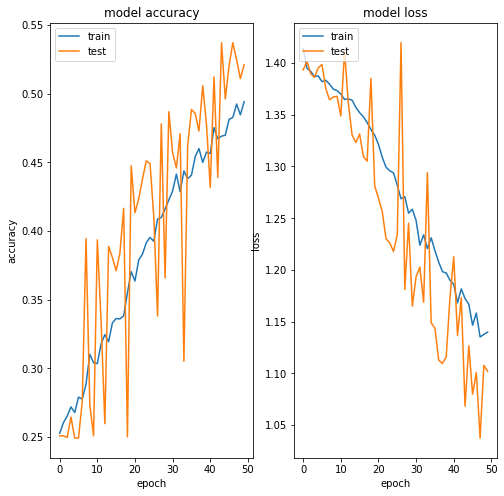

In [13]:
plot_learning_curve(history.history)
plt.show()

# RMSprop

In [20]:
LR = 0.001

In [21]:
#Build Model
model = Build_Model(RMSprop(lr=LR))

datagen = ImageDataGenerator(
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

history = model.fit_generator(datagen.flow(X_train,y_trainHot, batch_size=batch_size),
                        steps_per_epoch=len(X_train) / batch_size, epochs=epochs, validation_data = [X_test, y_testHot], verbose=2)

Epoch 1/50
 - 9s - loss: 1.6970 - acc: 0.2691 - val_loss: 1.3697 - val_acc: 0.2923
Epoch 2/50
 - 8s - loss: 1.3816 - acc: 0.3021 - val_loss: 1.3595 - val_acc: 0.3088
Epoch 3/50
 - 8s - loss: 1.3540 - acc: 0.3325 - val_loss: 1.3038 - val_acc: 0.3261
Epoch 4/50
 - 8s - loss: 1.3200 - acc: 0.3636 - val_loss: 1.2779 - val_acc: 0.3756
Epoch 5/50
 - 8s - loss: 1.3024 - acc: 0.3888 - val_loss: 1.2405 - val_acc: 0.4471
Epoch 6/50
 - 8s - loss: 1.2733 - acc: 0.4046 - val_loss: 1.2286 - val_acc: 0.4190
Epoch 7/50
 - 8s - loss: 1.2444 - acc: 0.4261 - val_loss: 1.2335 - val_acc: 0.3953
Epoch 8/50
 - 8s - loss: 1.2153 - acc: 0.4393 - val_loss: 1.1735 - val_acc: 0.4608
Epoch 9/50
 - 8s - loss: 1.1934 - acc: 0.4554 - val_loss: 1.1653 - val_acc: 0.4427
Epoch 10/50
 - 8s - loss: 1.1576 - acc: 0.4841 - val_loss: 1.1050 - val_acc: 0.4865
Epoch 11/50
 - 8s - loss: 1.1209 - acc: 0.4998 - val_loss: 1.2179 - val_acc: 0.4443
Epoch 12/50
 - 8s - loss: 1.1039 - acc: 0.5119 - val_loss: 1.7607 - val_acc: 0.3575
E

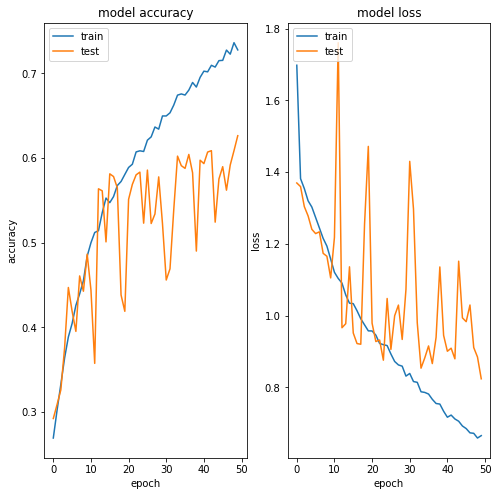

In [22]:
plot_learning_curve(history.history)
plt.show()

# Adam

In [26]:
LR = 0.001

In [27]:
#Build Model
model = Build_Model(Adam(lr=LR))

datagen = ImageDataGenerator(
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

history = model.fit_generator(datagen.flow(X_train,y_trainHot, batch_size=batch_size),
                        steps_per_epoch=len(X_train) / batch_size, epochs=epochs, validation_data = [X_test, y_testHot], verbose=2)

Epoch 1/50
 - 9s - loss: 1.8381 - acc: 0.2481 - val_loss: 1.3893 - val_acc: 0.2525
Epoch 2/50
 - 8s - loss: 1.3909 - acc: 0.2536 - val_loss: 1.3900 - val_acc: 0.2461
Epoch 3/50
 - 8s - loss: 1.3882 - acc: 0.2641 - val_loss: 1.3931 - val_acc: 0.2517
Epoch 4/50
 - 8s - loss: 1.3653 - acc: 0.3150 - val_loss: 1.3084 - val_acc: 0.4077
Epoch 5/50
 - 8s - loss: 1.3134 - acc: 0.3810 - val_loss: 1.2428 - val_acc: 0.4507
Epoch 6/50
 - 8s - loss: 1.2741 - acc: 0.3963 - val_loss: 1.2039 - val_acc: 0.4443
Epoch 7/50
 - 8s - loss: 1.2405 - acc: 0.4197 - val_loss: 1.1761 - val_acc: 0.4507
Epoch 8/50
 - 8s - loss: 1.2166 - acc: 0.4226 - val_loss: 1.1542 - val_acc: 0.4495
Epoch 9/50
 - 8s - loss: 1.1935 - acc: 0.4464 - val_loss: 1.1476 - val_acc: 0.4544
Epoch 10/50
 - 8s - loss: 1.1722 - acc: 0.4585 - val_loss: 1.1656 - val_acc: 0.4391
Epoch 11/50
 - 8s - loss: 1.1790 - acc: 0.4500 - val_loss: 1.1724 - val_acc: 0.4733
Epoch 12/50
 - 8s - loss: 1.1223 - acc: 0.5013 - val_loss: 1.1171 - val_acc: 0.4708
E

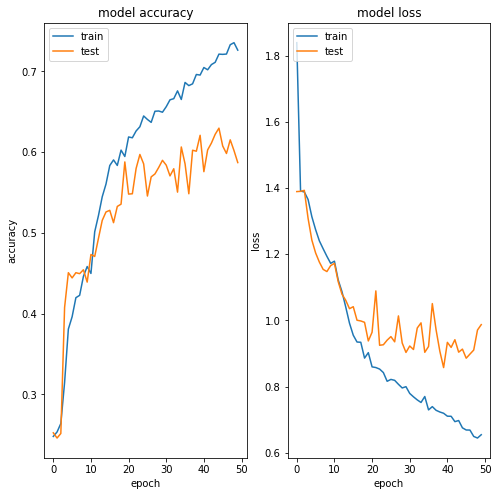

In [28]:
plot_learning_curve(history.history)
plt.show()

In [33]:
LR = 0.002

In [34]:
#Build Model
model = Build_Model(Adam(lr=LR))

datagen = ImageDataGenerator(
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

history = model.fit_generator(datagen.flow(X_train,y_trainHot, batch_size=batch_size),
                        steps_per_epoch=len(X_train) / batch_size, epochs=epochs, validation_data = [X_test, y_testHot], verbose=2)

Epoch 1/50
 - 9s - loss: 1.6826 - acc: 0.2488 - val_loss: 1.3840 - val_acc: 0.2819
Epoch 2/50
 - 8s - loss: 1.3833 - acc: 0.2832 - val_loss: 1.3846 - val_acc: 0.2577
Epoch 3/50
 - 9s - loss: 1.3766 - acc: 0.2974 - val_loss: 1.3706 - val_acc: 0.3325
Epoch 4/50
 - 25s - loss: 1.3592 - acc: 0.3310 - val_loss: 1.3506 - val_acc: 0.3836
Epoch 5/50
 - 40s - loss: 1.3375 - acc: 0.3567 - val_loss: 1.3080 - val_acc: 0.4326
Epoch 6/50
 - 9s - loss: 1.3062 - acc: 0.3906 - val_loss: 1.2585 - val_acc: 0.4431
Epoch 7/50
 - 8s - loss: 1.2712 - acc: 0.4007 - val_loss: 1.2081 - val_acc: 0.4656
Epoch 8/50
 - 8s - loss: 1.2406 - acc: 0.4233 - val_loss: 1.2387 - val_acc: 0.4029
Epoch 9/50
 - 8s - loss: 1.2096 - acc: 0.4448 - val_loss: 1.2464 - val_acc: 0.3916
Epoch 10/50
 - 9s - loss: 1.2002 - acc: 0.4419 - val_loss: 1.2655 - val_acc: 0.4013
Epoch 11/50
 - 8s - loss: 1.1846 - acc: 0.4535 - val_loss: 1.2795 - val_acc: 0.4089
Epoch 12/50
 - 8s - loss: 1.1506 - acc: 0.4725 - val_loss: 1.2220 - val_acc: 0.4298

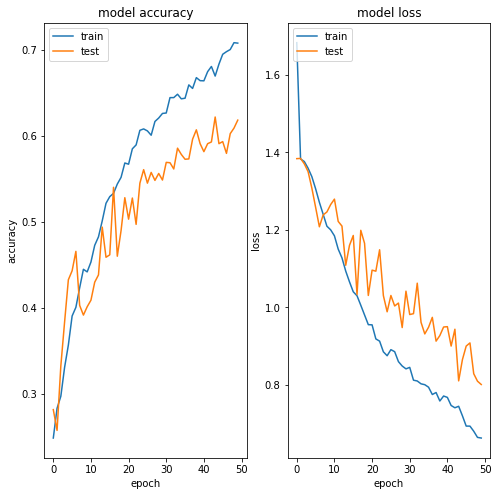

In [35]:
plot_learning_curve(history.history)
plt.show()

In [37]:
LR = 0.0005

In [38]:
#Build Model
model = Build_Model(Adam(lr=LR))

datagen = ImageDataGenerator(
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

history = model.fit_generator(datagen.flow(X_train,y_trainHot, batch_size=batch_size),
                        steps_per_epoch=len(X_train) / batch_size, epochs=epochs, validation_data = [X_test, y_testHot], verbose=2)

Epoch 1/50
 - 9s - loss: 1.4132 - acc: 0.2803 - val_loss: 1.3573 - val_acc: 0.3164
Epoch 2/50
 - 8s - loss: 1.3297 - acc: 0.3450 - val_loss: 1.2527 - val_acc: 0.4475
Epoch 3/50
 - 8s - loss: 1.2846 - acc: 0.3809 - val_loss: 1.2016 - val_acc: 0.4439
Epoch 4/50
 - 8s - loss: 1.2335 - acc: 0.4283 - val_loss: 1.1844 - val_acc: 0.4769
Epoch 5/50
 - 8s - loss: 1.1951 - acc: 0.4525 - val_loss: 1.1482 - val_acc: 0.4797
Epoch 6/50
 - 8s - loss: 1.1684 - acc: 0.4786 - val_loss: 1.1108 - val_acc: 0.4897
Epoch 7/50
 - 8s - loss: 1.1277 - acc: 0.5024 - val_loss: 1.1197 - val_acc: 0.4986
Epoch 8/50
 - 8s - loss: 1.0989 - acc: 0.5273 - val_loss: 1.0613 - val_acc: 0.4954
Epoch 9/50
 - 8s - loss: 1.0774 - acc: 0.5266 - val_loss: 1.1610 - val_acc: 0.4620
Epoch 10/50
 - 8s - loss: 1.0569 - acc: 0.5361 - val_loss: 1.0576 - val_acc: 0.5103
Epoch 11/50
 - 8s - loss: 1.0132 - acc: 0.5636 - val_loss: 1.0207 - val_acc: 0.5275
Epoch 12/50
 - 8s - loss: 1.0028 - acc: 0.5643 - val_loss: 0.9951 - val_acc: 0.5726
E

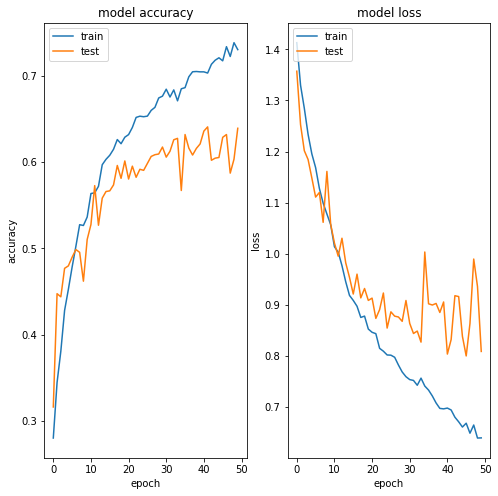

In [39]:
plot_learning_curve(history.history)
plt.show()

In [41]:
LR = 0.003

In [42]:
#Build Model
model = Build_Model(Adam(lr=LR))

datagen = ImageDataGenerator(
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

history = model.fit_generator(datagen.flow(X_train,y_trainHot, batch_size=batch_size),
                        steps_per_epoch=len(X_train) / batch_size, epochs=epochs, validation_data = [X_test, y_testHot], verbose=2)

Epoch 1/50
 - 9s - loss: 1.5644 - acc: 0.2494 - val_loss: 1.3957 - val_acc: 0.2537
Epoch 2/50
 - 8s - loss: 1.3899 - acc: 0.2535 - val_loss: 1.3906 - val_acc: 0.2654
Epoch 3/50
 - 8s - loss: 1.3898 - acc: 0.2603 - val_loss: 1.3865 - val_acc: 0.2839
Epoch 4/50
 - 8s - loss: 1.3870 - acc: 0.2696 - val_loss: 1.3847 - val_acc: 0.2525
Epoch 5/50
 - 8s - loss: 1.3826 - acc: 0.2849 - val_loss: 1.3589 - val_acc: 0.3386
Epoch 6/50
 - 8s - loss: 1.3776 - acc: 0.2939 - val_loss: 1.3390 - val_acc: 0.3703
Epoch 7/50
 - 8s - loss: 1.3740 - acc: 0.3067 - val_loss: 1.3372 - val_acc: 0.3607
Epoch 8/50
 - 8s - loss: 1.3793 - acc: 0.2912 - val_loss: 1.3278 - val_acc: 0.3591
Epoch 9/50
 - 8s - loss: 1.3616 - acc: 0.3175 - val_loss: 1.3129 - val_acc: 0.3643
Epoch 10/50
 - 8s - loss: 1.3747 - acc: 0.3107 - val_loss: 1.3222 - val_acc: 0.3687
Epoch 11/50
 - 8s - loss: 1.3694 - acc: 0.3092 - val_loss: 1.3330 - val_acc: 0.2984
Epoch 12/50
 - 8s - loss: 1.3628 - acc: 0.3227 - val_loss: 1.2983 - val_acc: 0.4005
E

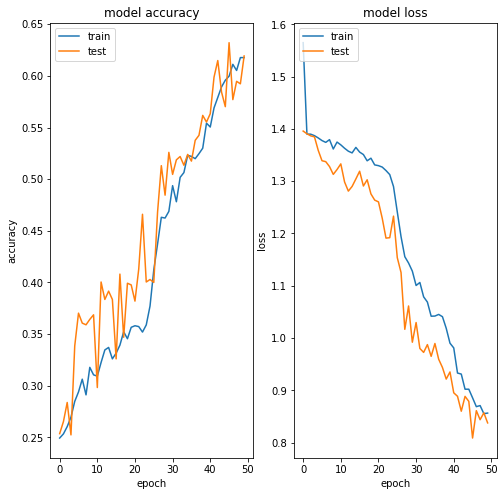

In [43]:
plot_learning_curve(history.history)
plt.show()